## Import Library

In [1]:
# !pip install  dgl -f https://data.dgl.ai/wheels/cu121/repo.html
# !pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html
# !pip install cudart
# !pip install pyspark
# !pip install py4j
# !pip install matplotlib

In [2]:
import findspark
findspark.init()

In [105]:
import os, sys
os.environ['DGLBACKEND'] = 'pytorch'
from copy import deepcopy
import numpy as np
import pandas as pd

import torch as th
import torch.nn as nn
from torch import optim
import torch.nn.functional as Fx
import networkx as nx
import itertools
import plotly.express as px

from pyspark.sql.functions import *
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import dgl
from itertools import combinations
%matplotlib inline
os.environ['DGLBACKEND'] = 'pytorch'
import dgl
from dgl import function as fn
from dgl.dataloading import DataLoader
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [106]:
print(f"Torch version: {th.__version__}.  CUDA version: {th.version.cuda}")

Torch version: 2.1.2.  CUDA version: 12.1


In [107]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, Bucketizer, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType

In [108]:
scala_version = '2.12'  # your scala version
spark_version = '3.5.0' # your spark version
packages = [
    f'org.apache.spark:spark-sql-kafka-0-10_{scala_version}:{spark_version}',
    'org.apache.kafka:kafka-clients:3.6.0' #your kafka version
]
spark = SparkSession.builder.master("local").appName("kafka-example").config("spark.jars.packages", ",".join(packages)).getOrCreate()
spark

## Load Dataset

In [109]:
test = spark.read.csv('data/test.csv', header = True, inferSchema= 'True').cache()
train = spark.read.csv('data/training.csv', header = True, inferSchema= 'True').cache()

In [110]:
df_train = train.withColumn("dataset", lit("train"))
df_test = test.withColumn("FraudResult", lit(None).cast("integer"))
df_test = df_test.withColumn("dataset", lit("test"))

In [111]:
df = df_train.union(df_test)

In [112]:
df.groupBy("dataset").count().show()

+-------+-----+
|dataset|count|
+-------+-----+
|  train|95662|
|   test|45019|
+-------+-----+



## Node Features

In [11]:
def preprocess_data(df, categorical_cols):
    # Categorical Features Encoding
    indexers = [StringIndexer(inputCol=col_name, outputCol=col_name + "_index") for col_name in categorical_cols]
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], outputCols=[col_name + "_encoded" for col_name in categorical_cols])
    pipeline = Pipeline(stages=indexers + [encoder])
    df_encoded = pipeline.fit(df).transform(df)
    df_encoded = df_encoded.drop(*categorical_cols)

    # Binary Encoding for 'Amount' Feature
    df_encoded = df_encoded.withColumn("Amount_encoded", when(col("Amount") > 0, 1).otherwise(0))

    # Logarithmic Transformation for 'Value' Feature
    df_encoded = df_encoded.withColumn("Value_log", log("Value"))

    # Concatenation of Numerical Features
    assembler = VectorAssembler(inputCols=["Amount_encoded", "Value_log"], outputCol="numerical_features")
    df_assembled = assembler.transform(df_encoded)

    # Min-Max Scaling
    scaler = MinMaxScaler(inputCol="numerical_features", outputCol="scaled_numerical_features")
    scaler_model = scaler.fit(df_assembled)
    df_final = scaler_model.transform(df_assembled)

    # Select the final features
    final_cols = [col_name + "_encoded" for col_name in categorical_cols] + ["scaled_numerical_features"]
    assembler_final = VectorAssembler(inputCols=final_cols, outputCol="features")
    features_transformed = assembler_final.transform(df_final)

    return features_transformed

In [12]:
categorical_cols = ['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'PricingStrategy']
df_processed = preprocess_data(df, categorical_cols)

## Construct Nodes

In [13]:
def index_nodes(df, node_col):
    indexer_stages = []

    for col_name in node_col:
        indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_idx", handleInvalid="keep")
        indexer_stages.append(indexer)

    indexed_df = df
    for index in indexer_stages:
        indexed_df = index.fit(indexed_df).transform(indexed_df)

    for col_name in [f"{col_name}_idx" for col_name in node_col]:
        df_transformed = indexed_df.withColumn(col_name, col(col_name).cast("int"))

    return df_transformed

In [14]:
node_col = ['TransactionId', 'AccountId', 'SubscriptionId']
final_transformed_df = index_nodes(df_processed, node_col)

In [15]:
feature_cols = [f"{col}_encoded" for col in categorical_cols] + ["scaled_numerical_features"]
feature_cols

['ProviderId_encoded',
 'ProductId_encoded',
 'ProductCategory_encoded',
 'ChannelId_encoded',
 'PricingStrategy_encoded',
 'scaled_numerical_features']

In [16]:
final_transformed_df.select(
    'TransactionId_idx', 'AccountId_idx', 'SubscriptionId_idx',
    'ProviderId_encoded',
    'ProductId_encoded',
    'ProductCategory_encoded',
    'ChannelId_encoded',
    'PricingStrategy_encoded',
    'scaled_numerical_features',
    'features', 'FraudResult').show()

+-----------------+-------------+------------------+------------------+-----------------+-----------------------+-----------------+-----------------------+-------------------------+--------------------+-----------+
|TransactionId_idx|AccountId_idx|SubscriptionId_idx|ProviderId_encoded|ProductId_encoded|ProductCategory_encoded|ChannelId_encoded|PricingStrategy_encoded|scaled_numerical_features|            features|FraudResult|
+-----------------+-------------+------------------+------------------+-----------------+-----------------------+-----------------+-----------------------+-------------------------+--------------------+-----------+
|         114984.0|        208.0|               208|     (5,[1],[1.0])|   (26,[2],[1.0])|          (9,[1],[1.0])|    (4,[0],[1.0])|          (3,[0],[1.0])|     [1.0,0.4032088588...|(49,[1,7,32,40,44...|          0|
|         111539.0|          0.0|                 0|     (5,[0],[1.0])|   (26,[0],[1.0])|          (9,[0],[1.0])|    (4,[1],[1.0])|         

## Construct Edges

In [17]:
def create_edges_df(node_id_cols, final_transformed_df):
    temp = list(combinations(node_id_cols, 2))
    node_pairs = [(pair[0], pair[1]) for pair in temp] + [(pair[1], pair[0]) for pair in temp]

    edges_schema = StructType([
        StructField("src",  IntegerType(), True),
        StructField("dst", IntegerType(), True),
        StructField("relation", StringType(), True)
    ])

    edges_data = []
    edgesDF = SparkSession.builder.getOrCreate().createDataFrame(edges_data, schema=edges_schema)

    def create_edges_and_update_dict(src_type, dst_type):
        relation = f"{src_type}-{dst_type}"
        tempDF = final_transformed_df.select(src_type, dst_type).distinct()
        tempDF = tempDF.withColumn("relation", lit(relation))

        nonlocal edgesDF
        edgesDF = edgesDF.union(tempDF.select(
            col(src_type),
            col(dst_type),
            col("relation"),
        ))

    for src_type, dst_type in node_pairs:
        create_edges_and_update_dict(src_type, dst_type)

    relation = edgesDF.select("relation").distinct().collect()
    edges_dict = dict()
    for rlt in relation:
        temp = rlt["relation"]
        f1 = temp.split("-")[0]
        f2 = temp.split("-")[1]
        fwd = (f1, temp, f2)
        current_relation_edges = edgesDF.filter(edgesDF["relation"] == temp).select("src", "dst").orderBy(asc('src'))
        edges = current_relation_edges.toPandas().values
        src = edges[:, 0]
        dst = edges[:, 1]
        edges_dict[fwd] = (th.tensor(src, dtype=th.int64), th.tensor(dst, dtype=th.int64))

    return edgesDF, edges_dict

In [18]:
node_id_cols = ['TransactionId_idx', 'AccountId_idx', 'SubscriptionId_idx']
edgesDF, edges_dict = create_edges_df(node_id_cols, final_transformed_df)

In [19]:
for key, value in edges_dict.items():
    src, dst = value
    print(f"{key}: (src: {src}, dst: {dst}, dtype: {src.dtype})")

('TransactionId_idx', 'TransactionId_idx-AccountId_idx', 'AccountId_idx'): (src: tensor([     0,      1,      2,  ..., 140678, 140679, 140680]), dst: tensor([185,  54,   0,  ..., 226,   1,   0]), dtype: torch.int64)
('TransactionId_idx', 'TransactionId_idx-SubscriptionId_idx', 'SubscriptionId_idx'): (src: tensor([     0,      1,      2,  ..., 140678, 140679, 140680]), dst: tensor([184,  53,   0,  ..., 226,   0,   0]), dtype: torch.int64)
('AccountId_idx', 'AccountId_idx-SubscriptionId_idx', 'SubscriptionId_idx'): (src: tensor([   0,    0,    1,  ..., 4838, 4839, 4840]), dst: tensor([1044,    0,    0,  ..., 4467, 4109, 3913]), dtype: torch.int64)
('AccountId_idx', 'AccountId_idx-TransactionId_idx', 'TransactionId_idx'): (src: tensor([   0,    0,    0,  ..., 4838, 4839, 4840]), dst: tensor([138983,  35386,  94185,  ...,  32460,  97653,  52210]), dtype: torch.int64)
('SubscriptionId_idx', 'SubscriptionId_idx-TransactionId_idx', 'TransactionId_idx'): (src: tensor([   0,    0,    0,  ..., 4

## Construct Graph

In [20]:
def construct_heterogeneous_graph(df_transformed, edges_dict):
    hg = dgl.heterograph(edges_dict)
    y = df_transformed.select(col('FraudResult'))
    y_txn = y.toPandas().values.ravel()
    baseline = y_txn[y_txn >= 0].mean()

    label_feat = dict()
    for ntype in hg.ntypes:
        if ntype == 'TransactionId_idx':
            continue
        label_feat[ntype] = th.zeros(hg.number_of_nodes(ntype)) + baseline

    label_feat['TransactionId_idx'] = th.tensor(np.nan_to_num(y_txn, nan=baseline)).float()
    hg.ndata['label'] = label_feat

    features_array = np.array(df_transformed.select("features").rdd.map(lambda x: x.features.toArray()).collect())

    for ntype in hg.ntypes:
        if ntype == 'TransactionId_idx':
            X_tmp = th.tensor(features_array).float()  # the natural features
        else:
            # random values as features
            X_rand = th.rand((hg.num_nodes(ntype), features_array.shape[1] - 1)) - 0.5
            in_degrees = th.zeros(hg.num_nodes(ntype))

            for cetype in hg.canonical_etypes:
                if ntype == cetype[2]:
                    in_degrees += hg.in_degrees(etype=cetype)

            in_degrees = th.log(in_degrees).reshape((-1, 1))
            in_degrees -= in_degrees.mean()

            X_tmp = th.hstack([X_rand, in_degrees])

        hg.nodes[ntype].data['feat'] = X_tmp

    return hg

In [21]:
hg = construct_heterogeneous_graph(final_transformed_df, edges_dict)

In [92]:
hg

Graph(num_nodes={'AccountId_idx': 4841, 'SubscriptionId_idx': 4836, 'TransactionId_idx': 140681},
      num_edges={('AccountId_idx', 'AccountId_idx-SubscriptionId_idx', 'SubscriptionId_idx'): 4843, ('AccountId_idx', 'AccountId_idx-TransactionId_idx', 'TransactionId_idx'): 140681, ('SubscriptionId_idx', 'SubscriptionId_idx-AccountId_idx', 'AccountId_idx'): 4843, ('SubscriptionId_idx', 'SubscriptionId_idx-TransactionId_idx', 'TransactionId_idx'): 140681, ('TransactionId_idx', 'TransactionId_idx-AccountId_idx', 'AccountId_idx'): 140681, ('TransactionId_idx', 'TransactionId_idx-SubscriptionId_idx', 'SubscriptionId_idx'): 140681},
      metagraph=[('AccountId_idx', 'SubscriptionId_idx', 'AccountId_idx-SubscriptionId_idx'), ('AccountId_idx', 'TransactionId_idx', 'AccountId_idx-TransactionId_idx'), ('SubscriptionId_idx', 'AccountId_idx', 'SubscriptionId_idx-AccountId_idx'), ('SubscriptionId_idx', 'TransactionId_idx', 'SubscriptionId_idx-TransactionId_idx'), ('TransactionId_idx', 'AccountId_id

In [22]:
len(hg.ndata['label']['TransactionId_idx'].numpy())

140681

In [23]:
hg.ndata['feat']

{'AccountId_idx': tensor([[ 0.2708, -0.3367, -0.4279,  ..., -0.3970,  0.2374,  8.6606],
         [-0.0872, -0.1601, -0.2390,  ...,  0.3015, -0.3564,  6.6199],
         [-0.4667,  0.4160, -0.0109,  ..., -0.3914, -0.4045,  6.4395],
         ...,
         [ 0.4946,  0.4493, -0.3844,  ..., -0.1628,  0.1944, -1.2996],
         [ 0.3890, -0.1910,  0.2838,  ...,  0.0465, -0.0424, -1.2996],
         [ 0.1237, -0.3273,  0.3457,  ..., -0.2402,  0.3766, -1.2996]]),
 'SubscriptionId_idx': tensor([[-0.1256,  0.3435,  0.2953,  ..., -0.4379, -0.2306,  8.7832],
         [-0.4441,  0.3602, -0.3968,  ..., -0.4057, -0.0919,  6.4400],
         [-0.2336, -0.3350, -0.1284,  ...,  0.2750, -0.1882,  5.5894],
         ...,
         [ 0.3776, -0.4237,  0.1226,  ..., -0.0550,  0.4289, -1.2991],
         [ 0.2291,  0.0664,  0.3979,  ..., -0.1379,  0.1195, -1.2991],
         [ 0.1369, -0.1319,  0.3620,  ...,  0.3416, -0.0517, -1.2991]]),
 'TransactionId_idx': tensor([[0.0000, 1.0000, 0.0000,  ..., 0.0000, 1.0000, 

In [24]:
hg

Graph(num_nodes={'AccountId_idx': 4841, 'SubscriptionId_idx': 4836, 'TransactionId_idx': 140681},
      num_edges={('AccountId_idx', 'AccountId_idx-SubscriptionId_idx', 'SubscriptionId_idx'): 4843, ('AccountId_idx', 'AccountId_idx-TransactionId_idx', 'TransactionId_idx'): 140681, ('SubscriptionId_idx', 'SubscriptionId_idx-AccountId_idx', 'AccountId_idx'): 4843, ('SubscriptionId_idx', 'SubscriptionId_idx-TransactionId_idx', 'TransactionId_idx'): 140681, ('TransactionId_idx', 'TransactionId_idx-AccountId_idx', 'AccountId_idx'): 140681, ('TransactionId_idx', 'TransactionId_idx-SubscriptionId_idx', 'SubscriptionId_idx'): 140681},
      metagraph=[('AccountId_idx', 'SubscriptionId_idx', 'AccountId_idx-SubscriptionId_idx'), ('AccountId_idx', 'TransactionId_idx', 'AccountId_idx-TransactionId_idx'), ('SubscriptionId_idx', 'AccountId_idx', 'SubscriptionId_idx-AccountId_idx'), ('SubscriptionId_idx', 'TransactionId_idx', 'SubscriptionId_idx-TransactionId_idx'), ('TransactionId_idx', 'AccountId_id

## Modeling

In [25]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score

In [93]:
def plot_roc(y_trues, y_preds, labels, x_max=1.0):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax.plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')

def plot_pr(y_trues, y_preds, labels):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        auc = roc_auc_score(y_true, y_pred)
        pr, re, thresholds = precision_recall_curve(y_true, y_pred)
        ax.plot(re, pr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

        # Calculate F1 score
        epsilon = 1e-7  # Small value to avoid division by zero
        re_pr_sum = re + pr
        mask = re_pr_sum > epsilon
        f1_scores = 3 * 2 * re * pr / np.where(mask, re_pr_sum, 1)
        print(labels[i])
        best_threshold = thresholds[np.argmax(f1_scores)]
        print('Best threshold: ', best_threshold)
        print('Best F1-Score: ', np.max(f1_scores))

    ax.legend()
    ax.grid()
    ax.set_title('Precision-Recall curve')
    ax.set_xlabel('Recall')
    _ = ax.set_ylabel('Precision')

In [27]:
y = final_transformed_df.select(col('FraudResult'))
y_txn = y.toPandas().values.ravel()
baseline = y_txn[y_txn >= 0].mean()
features_array = np.array(final_transformed_df.select("features").rdd.map(lambda x: x.features.toArray()).collect())

In [28]:
y_txn.shape[0]

140681

In [29]:
N_labels = df.filter(df['dataset'] == 'train').count()
N_labels

95662

In [30]:
# Indicies w/ labels (training data)
labeled_mask = np.zeros_like(y_txn, dtype=bool)
labeled_mask[:N_labels] = 1
assert y_txn[labeled_mask].mean()==baseline

In [31]:
# Split of training data into train/validation sets
rng = np.random.default_rng(1)
train_rate = 0.7
train_mask = (rng.random(y_txn.shape[0])>(1-train_rate))&labeled_mask
val_mask = ~train_mask&labeled_mask
test_mask = ~labeled_mask

In [32]:
# Fraud rate in train/val
y_txn[train_mask].mean(), y_txn[val_mask].mean()

(0.0019413706076490001, 0.002195198438969999)

In [33]:
# Fraud count in train/val
y_txn[train_mask].sum(), y_txn[val_mask].sum()

(130.0, 63.0)

## EDA

In [154]:
import networkx as nx
def draw_kkl_hg(hg, **kwargs):

    hg_label = hg.ndata['label']['TransactionId_idx'].int()

    g = dgl.to_homogeneous(hg)
    g.ndata['ntype'] = g.ndata['_TYPE']
    nx_G = g.to_networkx(node_attrs=['ntype']).to_undirected()
    fig, ax = plt.subplots(figsize=(10,10))

    pos = nx.spring_layout(nx_G, k=5/np.sqrt(g.num_nodes()))

    nodeShapes = ["^", "s", "o", "v"]
    # For each node class...
    for idx, ntype in enumerate(hg.ntypes):
        aShape = nodeShapes[idx]
        if ntype=='TransactionId_idx':
            node_color = ['blue' if v==0 else 'red' if v==1 else 'black' for v in hg_label]
        else:
            node_color = "grey"
        nx.draw_networkx_nodes(
            nx_G, pos, node_shape=aShape, node_color=node_color, cmap='bwr', node_size=200,
            nodelist = [sNode[0] for sNode in nx_G.nodes(data=True) if sNode[1]["ntype"] == idx]
        )

    # Draw the edges between the nodes
    nx.draw_networkx_edges(nx_G, pos)

def plot_neighborhood(dataloader, N_plots=5):
    nstats = dict()
    for i, (input_nodes, output_nodes, blocks) in enumerate(dataloader):
        if i >= N_plots:
            break
        hg_tmp = dgl.node_subgraph(hg, input_nodes)
        draw_kkl_hg(hg_tmp)


def neighborhood_stats(hg):
    def mp_fn_dict(in_feat, out_feat):
        return {
            cetype: (fn.copy_u(in_feat, 'm'), fn.sum('m', out_feat))
            for cetype in hg.canonical_etypes
        }

    with hg.local_scope():
        degree_data = dict()
        for ntype in hg.ntypes:
            in_degrees = th.zeros(hg.num_nodes(ntype))
            for cetype in hg.canonical_etypes:
                if cetype[2]==ntype:
#                     print(cetype)
                    in_degrees += hg.in_degrees(etype=cetype)
            degree_data[ntype] = in_degrees

        hg.ndata['degree'] = degree_data
        hg.ndata['N_fraud'] = {
            ntype: (labels==1).float() for ntype, labels in hg.ndata['label'].items()
        }

        hg.multi_update_all(mp_fn_dict('degree', 'd_sum'), cross_reducer='sum')
        hg.multi_update_all(mp_fn_dict('N_fraud', 'total_fraud'), cross_reducer='sum')
        hg.multi_update_all(mp_fn_dict('total_fraud', 'total_fraud_2hop'), cross_reducer='sum')

        n_2hop = hg.ndata['d_sum']['TransactionId_idx']
        fraud_rate_2hop = hg.ndata['total_fraud_2hop']['TransactionId_idx'] / hg.ndata['d_sum']['TransactionId_idx']
    return n_2hop, fraud_rate_2hop

In [155]:
n_hops = 5
sampler = dgl.dataloading.MultiLayerNeighborSampler([10]*n_hops)
dataloader_legit = DataLoader(
    hg, {'TransactionId_idx': np.where(y_txn==1)[0]}, sampler,
    batch_size=5, shuffle=False, drop_last=False, num_workers=0)

C:\Users\Windows\miniconda3\envs\my_env\lib\site-packages\dgl\dataloading\dataloader.py:1149: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(
C:\Users\Windows\miniconda3\envs\my_env\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


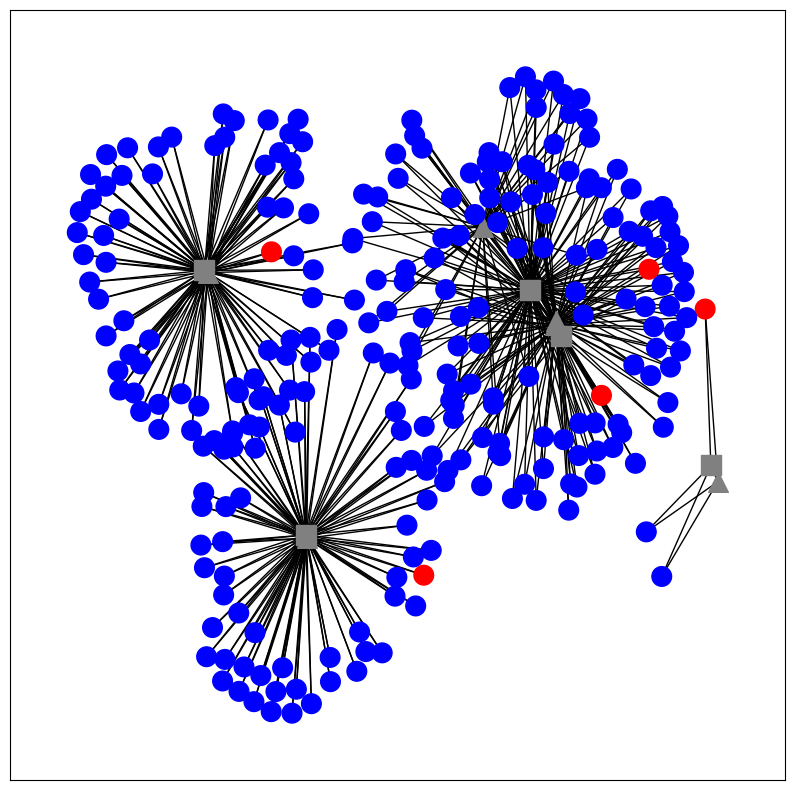

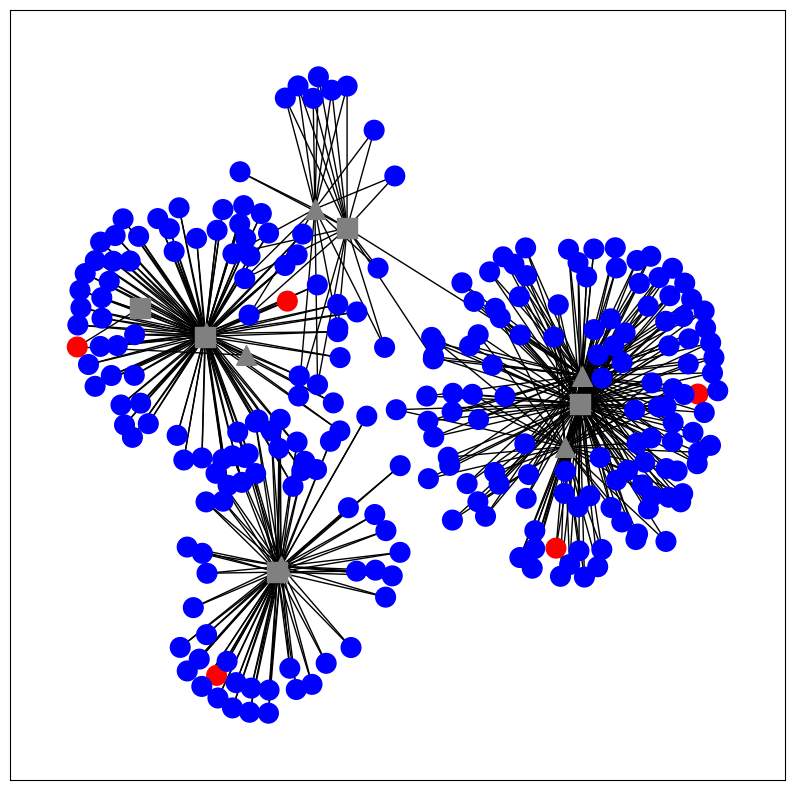

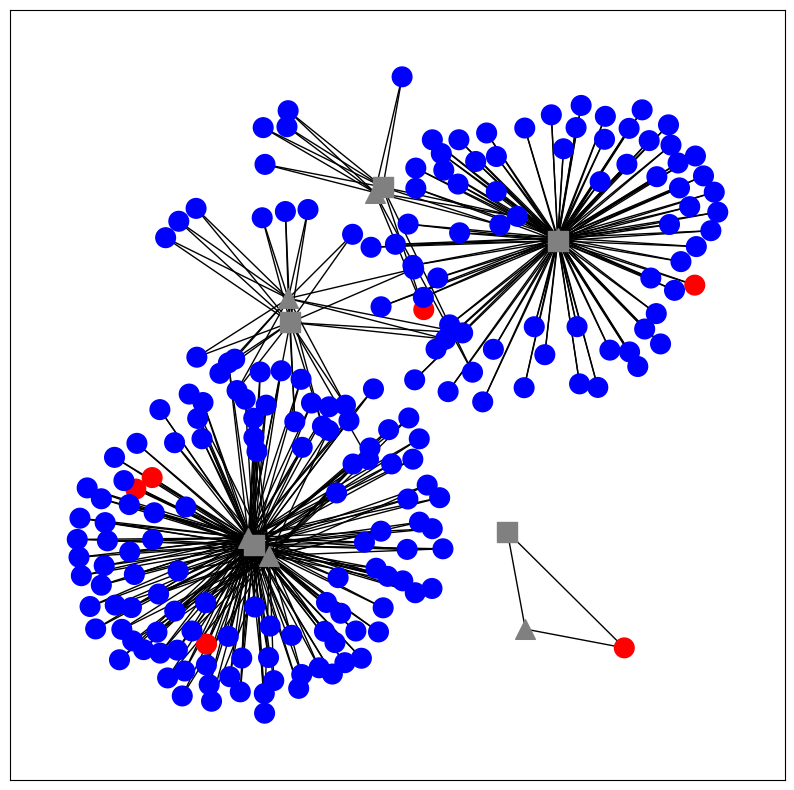

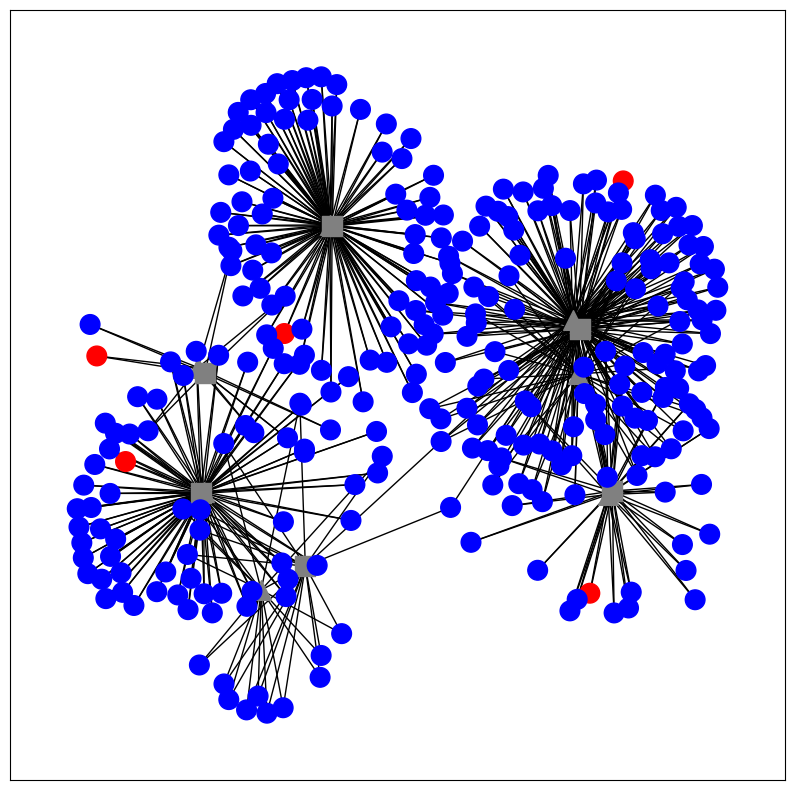

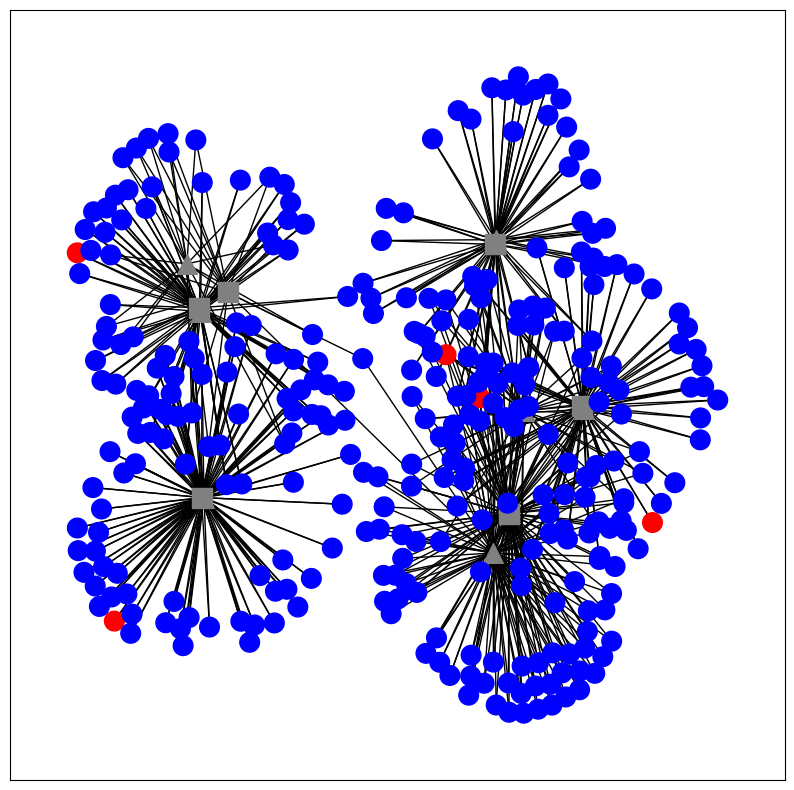

In [156]:
plot_neighborhood(dataloader_legit, N_plots=5)

## GCN

In [44]:
from dgl.nn import GraphConv, HeteroGraphConv, WeightBasis

In [45]:
def plot_losses(train_losses, val_losses, log=False):
    """
    Plots train/validation loss curves vs training epoch
    """
    fig, ax = plt.subplots()

    ax.plot(train_losses, label='Train')
    ax.plot(val_losses, label='Val')
    ax.set(xlabel='Epoch', ylabel='CrossEnt')
    if log:
        ax.set_yscale('log')
    ax.legend()
    ax.grid()

@th.no_grad()
def infer(model_cp, hg, mask, best_model_fp=None):
    if best_model_fp:
        print("loading from disk")
        model = deepcopy(model_cp)
        model.load_state_dict(th.load(best_model_fp))
    else:
        model = model_cp

    model.to(device)

    model.eval()

    features = hg.ndata['feat']

    sampler = dgl.dataloading.MultiLayerNeighborSampler([15]*len(model.convs))
    dataloader = DataLoader(
        hg,
         {'TransactionId_idx': th.where(mask)[0]},
        sampler,
        batch_size=1024,
        shuffle=False,
        drop_last=False,
        num_workers=0)

    y_preds = list()
    for input_nodes, output_nodes, blocks in dataloader:
        h = {k: features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
        blocks = [b.to(device) for b in blocks]

        logits = model(blocks, h)
        y_preds.append(logits.softmax(dim=1))

    return th.cat(y_preds).cpu()

@th.no_grad()
def test(model, hg, mask, best_path=None):
    model.eval()

    features = hg.ndata['feat']
    sampler = dgl.dataloading.MultiLayerNeighborSampler([15]*len(model.convs))
    dataloader = DataLoader(
        hg,
        {'TransactionId_idx': th.where(mask)[0]},
        sampler,
        batch_size=1024,
        shuffle=False,
        drop_last=False,
        num_workers=0
    )
    labels = hg.ndata['label']['TransactionId_idx'].long()

    correct = list()
    for input_nodes, output_nodes, blocks in dataloader:
        h = {k: features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
        blocks = [b.to(device) for b in blocks]

        logits = model(blocks, h)
        y_preds = logits.argmax(1)
        n_correct = (labels[output_nodes['TransactionId_idx']] == y_preds).sum().item()
        correct.append(n_correct)

    correct_tensor = th.tensor(correct, dtype=th.float32, device=device)
    acc = correct_tensor.sum() / th.where(mask)[0].shape[0]

    return acc.item()

def train_step(model, hg, features, train_mask, val_mask, optimizer, loss_fn, weight=False):
    """
    A single training step
    """
    model.train()
    optimizer.zero_grad()

    sampler = dgl.dataloading.MultiLayerNeighborSampler([15]*len(model.convs))
    dataloader = DataLoader(
        hg,
        {'TransactionId_idx': th.where(train_mask)[0]},
        sampler,
        batch_size=1024,
        shuffle=True,
        drop_last=False,
        num_workers=0)

    val_loader = DataLoader(
        hg,
        {'TransactionId_idx': th.where(val_mask)[0]},
        sampler,
        batch_size=1024,
        shuffle=False,
        drop_last=False,
        num_workers=0)

    train_losses = list()
    if weight:
        weight = th.tensor([1., 1/baseline]).float().to(device)
    else:
        weight = None

    labels = hg.ndata['label']['TransactionId_idx'].long()

    for input_nodes, output_nodes, blocks in dataloader:
        h = {k: features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
        blocks = [b.to(device) for b in blocks]

        logits = model(blocks, h)
        loss = loss_fn(logits, labels[output_nodes['TransactionId_idx']], weight=weight)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_losses.append(loss.item())


    val_losses = list()
    with th.no_grad():
        for input_nodes, output_nodes, blocks in val_loader:
            h = {k: features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
            blocks = [b.to(device) for b in blocks]

            logits = model(blocks, h)
            val_loss = loss_fn(logits, labels[output_nodes['TransactionId_idx']])
            val_losses.append(val_loss.item())

    return np.array(train_losses).mean(), np.array(val_losses).mean()

def train(hg, split_idx, model, epochs, evaluator,
          device, save_path, loss_fn=F.cross_entropy, lr=0.01,
          es_criteria=5, weight_class=False, verbose=False):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_metric = 1e10
    train_losses = list()
    val_losses = list()
    features = hg.ndata['feat']
    train_mask = split_idx['train'].to(device)
    val_mask = split_idx['valid'].to(device)
    es_iters = 0

    for e in range(1, epochs+1):

        # print("Training step")
        train_loss, val_loss = train_step(
            model, hg, features, train_mask, val_mask, optimizer, loss_fn, weight_class,
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Compute accuracy on training/validation/test
        # print("Train eval")
        train_acc = test(model, hg, train_mask)
        # print("Val eval")
        val_acc = test(model, hg, val_mask)

        val_metric = val_loss

        if val_metric > 1e5:
            print(f"Early stopping for huge loss: {val_metric}")
            break

        # Save the best validation accuracy and the corresponding test accuracy.
        if val_metric < best_val_metric  :
            best_val_metric = val_metric
            th.save(model.state_dict(), save_path)
            es_iters = 0
        else:
            es_iters += 1


        if e % 5 == 0 and verbose:
            print('In epoch {}, loss: {:.3f}, val metric: {:.3f} (best {:.3f})'.format(
                e, train_loss, val_metric, best_val_metric))

        if es_iters >= es_criteria:
            print(f"Early stopping at {e} epochs")
            break

    return np.array(train_losses), np.array(val_losses)

In [46]:
class RelGraphConvLayer(nn.Module):
    r"""Relational graph convolution layer.
    Parameters
    ----------
    in_feat : int
        Input feature size.
    out_feat : int
        Output feature size.
    rel_names : list[str]
        Relation names.
    num_bases : int, optional
        Number of bases. If is none, use number of relations. Default: None.
    weight : bool, optional
        True if a linear layer is applied after message passing. Default: True
    bias : bool, optional
        True if bias is added. Default: True
    activation : callable, optional
        Activation function. Default: None
    self_loop : bool, optional
        True to include self loop message. Default: False
    dropout : float, optional
        Dropout rate. Default: 0.0
    """
    def __init__(self,
                 in_feat,
                 out_feat,
                 rel_names,
                 *,
                 num_bases=None,
                 weight=True,
                 bias=True,
                 activation=None,
                 self_loop=False,
                 bn=False,
                 dropout=0.0):
        super(RelGraphConvLayer, self).__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.rel_names = rel_names
        self.num_bases = num_bases
        self.bias = bias
        self.activation = activation
        self.self_loop = self_loop
        self.bn = bn

        self.conv = HeteroGraphConv({
                rel : GraphConv(in_feat, out_feat, norm='right', weight=False, bias=False)
                for rel in rel_names
            })

        self.use_weight = weight
        self.use_basis = num_bases is not None and num_bases < len(self.rel_names) and weight
        if self.use_weight:
            if self.use_basis:
                self.basis = WeightBasis((in_feat, out_feat), num_bases, len(self.rel_names))
            else:
                self.weight = nn.Parameter(th.Tensor(len(self.rel_names), in_feat, out_feat))
                nn.init.xavier_uniform_(self.weight, gain=nn.init.calculate_gain('relu'))

        # bias
        if bias:
            self.h_bias = nn.Parameter(th.Tensor(out_feat))
            nn.init.zeros_(self.h_bias)

        # weight for self loop
        if self.self_loop:
            self.loop_weight = nn.Parameter(th.Tensor(in_feat, out_feat))
            nn.init.xavier_uniform_(self.loop_weight,
                                    gain=nn.init.calculate_gain('relu'))

        if self.bn:
            self.bn_layer = nn.BatchNorm1d(out_feat)

        self.dropout = nn.Dropout(dropout)

    def forward(self, g, inputs):
        """Forward computation
        Parameters
        ----------
        g : DGLHeteroGraph
            Input graph.
        inputs : dict[str, torch.Tensor]
            Node feature for each node type.
        Returns
        -------
        dict[str, torch.Tensor]
            New node features for each node type.
        """
        g = g.local_var()
        if self.use_weight:
            weight = self.basis() if self.use_basis else self.weight
            wdict = {self.rel_names[i] : {'weight' : w.squeeze(0)}
                     for i, w in enumerate(th.split(weight, 1, dim=0))}
        else:
            wdict = {}

        if g.is_block:
            inputs_src = inputs
            inputs_dst = {k: v[:g.number_of_dst_nodes(k)] for k, v in inputs.items()}
        else:
            inputs_src = inputs_dst = inputs

        hs = self.conv(g, inputs, mod_kwargs=wdict)

        def _apply(ntype, h):
            if self.self_loop:
                h = h + th.matmul(inputs_dst[ntype], self.loop_weight)
            if self.bias:
                h = h + self.h_bias
            if self.bn:
                h = self.bn_layer(h)
            if self.activation:
                h = self.activation(h)
            return self.dropout(h)
        return {ntype : _apply(ntype, h) for ntype, h in hs.items()}

In [47]:
class RGCN(nn.Module):
    def __init__(self, hg, in_feats, h_feats, num_classes, num_layers, num_bases,
                 self_loop=True, dropout=0, bn=False):

        super(RGCN, self).__init__()
        self.dropout = dropout

        # GNN layers
        self.convs = nn.ModuleList()
        activation_fn = nn.ReLU()
        self.convs.append(RelGraphConvLayer(
            in_feats, h_feats, hg.etypes, activation=activation_fn, dropout=dropout,
            num_bases=num_bases, self_loop=self_loop, bn=bn))

        for _ in range(num_layers-1):
            self.convs.append(RelGraphConvLayer(
                h_feats, h_feats, hg.etypes, activation=activation_fn, dropout=dropout,
                num_bases=num_bases, self_loop=self_loop, bn=bn
            ))

        # Output linear layer
        self.output_layer = nn.Linear(h_feats+in_feats, num_classes)

    def forward(self, blocks, in_feat):
        """
        The forward pass of the model, which applies all of the layers
        to a given graph and set of node features

        Args:
            g (DGLGraph): the graph used for Graph Convolutions
            in_feat (Tensor): the node features
        """
        h = in_feat
        for i, conv in enumerate(self.convs):
            h = conv(blocks[i], h)

        h_in = blocks[-1].dstdata['feat']['TransactionId_idx']
        h = self.output_layer(th.cat([h['TransactionId_idx'], h_in], dim=1))
        return h


class LabelSmoothing(nn.Module):
    """NLL loss with label smoothing.
    """
    def __init__(self, smoothing=0.0):
        """Constructor for the LabelSmoothing module.
        :param smoothing: label smoothing factor
        """
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target, weight=None):
        logprobs = nn.functional.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

In [48]:
split_mask = {
    'train': th.tensor(train_mask),
    'valid': th.tensor(val_mask),
    'test': th.tensor(test_mask)
}

In [49]:
split_mask['test'].numpy()

array([False, False, False, ...,  True,  True,  True])

In [50]:
loss_fn = LabelSmoothing(smoothing=0.1)

In [51]:
model_kwargs = dict(
    in_feats=features_array.shape[1], h_feats=256, num_classes=2,
    num_layers=2, dropout=0.1, num_bases=None,
    self_loop=False, bn=True,
)
model = RGCN(hg, **model_kwargs).to(device)
model

RGCN(
  (convs): ModuleList(
    (0): RelGraphConvLayer(
      (activation): ReLU()
      (conv): HeteroGraphConv(
        (mods): ModuleDict(
          (AccountId_idx-SubscriptionId_idx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (AccountId_idx-TransactionId_idx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (SubscriptionId_idx-AccountId_idx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (SubscriptionId_idx-TransactionId_idx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (TransactionId_idx-AccountId_idx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (TransactionId_idx-SubscriptionId_idx): GraphConv(in=49, out=256, normalization=right, activation=None)
        )
      )
      (bn_layer): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): RelGraphConv

In [115]:
features_array.shape[1]

49

In [42]:
# train_losses, val_losses = train(
#     hg.to(device), split_mask, model.to(device), 200, None,
#     device, 'models/rgcn2.pt', loss_fn=loss_fn, lr=0.001,
#     es_criteria=50, verbose=True, weight_class=True,
# )

In [43]:
# !curl -sSOL https://downloads.apache.org/kafka/3.6.1/kafka_2.13-3.6.1.tgz
# !tar -xzf kafka_2.13-3.6.1.tgz

In [94]:
# predictions using a trained model.
y_val_hat_rgcn = infer(model.to(device), hg.to(device), split_mask['valid'].to(device), 'models/rgcn2.pt')

loading from disk


RGCN
Best threshold:  0.08711628
Best F1-Score:  0.5714285714285714


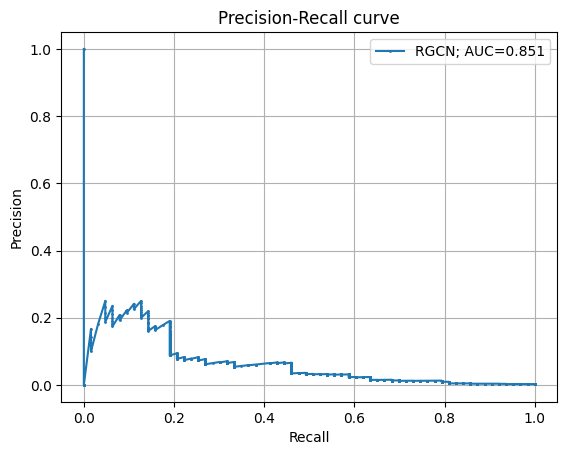

In [95]:
plot_pr(
    [y_txn[val_mask]],
    [y_val_hat_rgcn[:,1]],
    ['RGCN'],
)

In [ ]:
plot_roc(
    [y_txn[val_mask]]*5,
    [y_val_hat_rgcn[:,1]],
    ['RGCN'],
    x_max=0.05,
)

In [79]:
def predict_from_probabilities(y_probs):
    # Use argmax to get the index of the class with the highest probability
    predicted_classes = th.argmax(y_probs, dim=1)
    return predicted_classes

def get_corresponding_mask(df, df_transformed):
    df = df.select("TransactionId").dropDuplicates()
    transaction_id_list = [row.TransactionId for row in df.collect()]
    df_final = df_transformed.withColumn("mask", when(df_transformed.TransactionId.isin(transaction_id_list), True).otherwise(False))
    mask = [row.mask for row in df_final.select("mask").collect()]
    return th.tensor(mask)

In [77]:
import time
from random import randint
from time import sleep
from IPython.display import clear_output
from pyspark.sql.functions import from_json
import plotly.express as px

In [78]:
from kafka import KafkaConsumer
import json
from time import sleep
from IPython.display import clear_output
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType

# Define the schema for Kafka stream DataFrame
schema = StructType([
    StructField("TransactionId", StringType(), True),
    StructField("BatchId", StringType(), True),
    StructField("AccountId", StringType(), True),
    StructField("SubscriptionId", StringType(), True),
    StructField("CustomerId", StringType(), True),
    StructField("CurrencyCode", StringType(), True),
    StructField("CountryCode", IntegerType(), True),
    StructField("ProviderId", StringType(), True),
    StructField("ProductId", StringType(), True),
    StructField("ProductCategory", StringType(), True),
    StructField("ChannelId", StringType(), True),
    StructField("Amount", DoubleType(), True),
    StructField("Value", IntegerType(), True),
    StructField("TransactionStartTime", TimestampType(), True),
    StructField("PricingStrategy", IntegerType(), True)
])

kafka_params = {
    "kafka.bootstrap.servers": "localhost:9092",  # Change this to your Kafka broker
    "subscribe": "test_streaming",               # Change this to your Kafka topic
    "startingOffsets": "earliest"
}

In [80]:
np.bool = np.bool_
# Read streaming data from Kafka
kafka_stream_df = (
    spark.read.format("kafka")
    .option("kafka.bootstrap.servers", kafka_params["kafka.bootstrap.servers"])
    .option("subscribe", kafka_params["subscribe"])
    .option("startingOffsets", kafka_params["startingOffsets"])
    .load()
    .selectExpr("CAST(value AS STRING)")
    .select(from_json("value", schema).alias("data"))
    .select("data.*")
)

kafka_stream_df = kafka_stream_df.dropDuplicates().toPandas()

In [97]:
mask = get_corresponding_mask(kafka_stream_df, df)
tensor_mask = th.tensor(mask)
y_pred = infer(model.to(device), hg.to(device), tensor_mask.to(device) , 'models/rgcn.pt')
y_pred_labels = (y_pred[:, 1] > 0.21062215).int().numpy()
kafka_stream_df["Fraud_Predict"] = y_pred_labels

loading from disk


In [113]:
import plotly.express as px
def display_live_plot(df):
    # Create a scatter plot for fraudulent transactions
    fraud_df = df[df['Fraud_Predict'] == 1]
    fig = px.scatter(fraud_df, x="TransactionStartTime", y="Amount", color="Fraud_Predict", title="Live Streaming Data")

    # Overlay line plot for all transactions
    line_fig = px.line(df, x="TransactionStartTime", y="Amount", title="Live Streaming Data")

    # Update scatter plot with line plot data
    for trace in line_fig.data:
        fig.add_trace(trace)\

    fig.update_layout(
        autosize=False,
        width=1000,
        height=400,
    )
    fig.show()

batch_size = 5000
previous_batch = None
for x in range(0, 4):
    try:
        print("Showing live view refreshed every 5 seconds")
        print(f"Seconds passed: {x*5}")
        current_batch = kafka_stream_df.sample(batch_size)
        if previous_batch is not None:
            combined_df = pd.concat([previous_batch, current_batch])
            display_live_plot(combined_df)
        else:
            display_live_plot(current_batch)
        previous_batch = current_batch
        sleep(5)
        clear_output(wait=True)
    except KeyboardInterrupt:
        print("Break")
        break

print("Live view ended.")